In [126]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
#db.create_pgpass_file()


In [127]:
df=pd.read_csv('data.csv',sep=';')
df['date'] = pd.to_datetime(df['date'])
df.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10001,2010-06-30,-0.043421,6080.0,10.8600,66028.8000,NaN,0.000135,-0.050780,1,-0.043556,-0.050915
1,10001,2010-05-28,0.004829,6071.0,11.4000,69209.4000,66028.80,0.000114,-0.079240,1,0.004715,-0.079354
2,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.40,0.000118,0.020036,1,0.124267,0.019918
3,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.30,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.37,0.000061,0.034744,1,-0.000717,0.034683


# **Part 3: Betting Against Beta**

## Estimating rolling betas

In [128]:
#Copying df3frame for safe measure
df3=df.copy()


In [129]:
#Drop NaNs
df3=df3.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

#Remove scarce df3 
df3['N'] = df3.groupby(['permno'])['date'].transform('count')
df3 = df3[df3['N']>60].copy()

#Estimate Rolling Betas
cov_nm = df3.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
#beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

#reconstruct df
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
df3 = pd.merge(df3, beta_n, on=['date','permno'], how='left')

#Winsorsize
df3['beta'] = df3['beta'].clip(df3['beta'].quantile(0.05),df3['beta'].quantile(0.95))

#Show first 5 rows
df3.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N,beta
0,10001,2010-05-28,0.004829,6071.0,11.4000,69209.4000,66028.8000,0.000114,-0.079240,1,0.004715,-0.079354,91,NaN
1,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,91,NaN
2,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,91,NaN
3,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,91,NaN
4,10001,2010-01-29,-0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,91,NaN


## PF Decile

In [130]:
#Generate Quantiles
df3=df3.dropna(subset=['beta']).copy()
df3['beta_q']=df3.groupby('date')['beta'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df3.groupby(['date','beta_q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_q')['Rn'].mean()*12
ew_ret_std = ret_ew.groupby('beta_q')['Rn'].std()*(np.sqrt(12))
ew_rf_mean=df3.groupby('beta_q')['rf'].mean()*12
ew_sr=(ew_ret_mean-ew_rf_mean)/(ew_ret_std)



# Value-weighed pfs
df3['vw_Q']=df3['mcap']/(df3.groupby(['date','beta_q'])['mcap'].transform('sum'))
df3['ret_vw'] = df3['vw_Q']*df3['Rn']
ret_vw = df3.groupby(['date','beta_q'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_q')['ret_vw'].mean()*12
vw_ret_std = ret_vw.groupby('beta_q')['ret_vw'].std()*(np.sqrt(12))
vw_rf_mean=df3.groupby('beta_q')['rf'].mean()*12
vw_sr=(vw_ret_mean-vw_rf_mean)/(vw_ret_std)

In [131]:
#Constuct dataframes for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])

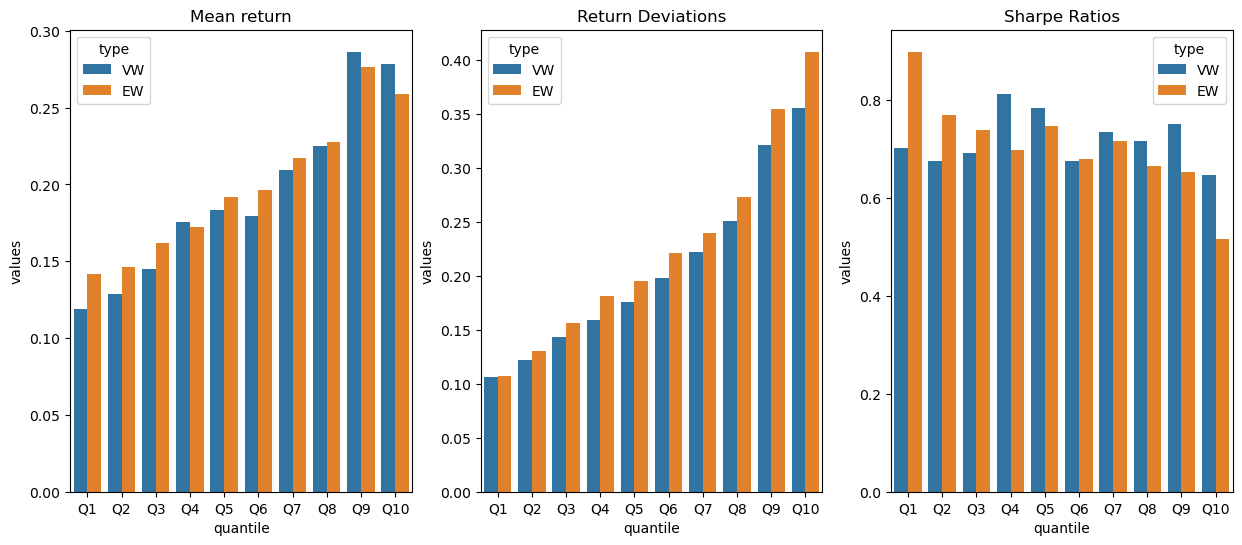

In [132]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()


## BAB PF Construction

In [133]:
# Weights
df3['z'] = df3.groupby('date')['beta'].transform(lambda x: x.rank())
df3['z_'] = df3['z']-df3.groupby('date')['z'].transform('mean')
df3['k'] = np.abs(df3['z_'])
df3['k'] = 2/df3.groupby('date')['k'].transform('sum')
df3['w_H'] = df3['k'] * df3['z_'] * (df3['z_']>0) 
df3['w_L'] = -df3['k'] * df3['z_'] * (df3['z_']<0)

# Weighted returns and beta
df3['beta_H'] = df3['w_H'] * df3['beta']
df3['beta_L'] = df3['w_L'] * df3['beta']
df3['R_H'] = df3['w_H'] * df3['Rn']
df3['R_L'] = df3['w_L'] * df3['Rn']
df3['R_H_e'] = df3['w_H'] * df3['Rn_e']
df3['R_L_e'] = df3['w_L'] * df3['Rn_e']
BAB = df3.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']


In [134]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,df3[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params[0]*12
idio_vol = (tmp['BAB2']-OLS_Reg.predict()).std()*np.sqrt(12)
market_rp = tmp['Rm_e'].mean()*12
market_vol = tmp['Rm_e'].std()*np.sqrt(12)
beta_bab = OLS_Reg.params[1]

print('Annualized Alpha of BAB factor: ', Alpha_bab, OLS_Reg.tvalues[0])
print('Sharpe Ratio of BAB factor: ',tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Idiosyncatic volatility: ',idio_vol)
print('Beta BAB: ',beta_bab)
print('Market Risk Premium: ',market_rp)
print('Market Volatility: ',market_vol)

Annualized Alpha of BAB factor:  0.07860672077198344 2.6950984948083216
Sharpe Ratio of BAB factor:  0.585810877701179
Idiosyncatic volatility:  0.13423154010417018
Beta BAB:  0.00035255512468768775
Market Risk Premium:  0.0782370197635887
Market Volatility:  0.1641776899936966


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_27732\3891231813.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Alpha_bab = OLS_Reg.params[0]*12
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_27732\3891231813.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_bab = OLS_Reg.params[1]
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_27732\3891231813.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print

# **Part 5: Idiosyncratic Volatility**


In [135]:
df5=df.copy()
df5.dropna(subset=['Rn_e','Rm_e'],inplace=True)


In [136]:
volatilities = {}
window=60
min_periods=36
for permno, group in df5.groupby('permno'):
    rolling = group.set_index('date')[['Rn_e', 'Rm_e']].rolling(window, min_periods=min_periods)
    curr_dict = {}
    for window in rolling:
        X = sm.add_constant(window[['Rm_e']])
        y = window['Rn_e']
        results = sm.OLS(y, X).fit()
        preds = results.predict(X)
        idio_vol = (y - preds).std()*np.sqrt(12)
        date = window.iloc[-1].name
        curr_dict[date] = idio_vol 
    volatilities[permno] = curr_dict

# transform the dictionary into a DataFrame
idio_df = pd.DataFrame(volatilities).T.stack().reset_index().rename(columns={'level_0':'permno', 'level_1':'date', 0:'idio_vol'})
# export the DataFrame to a csv file
idio_df.to_csv('idio_vol.csv', index=False)

ValueError: window must be an integer 0 or greater

In [137]:
df_idio=pd.read_csv('idio_vol.csv')
df_idio['date']=pd.to_datetime(df_idio['date'])
df_idio.head()

,permno,date,idio_vol
0,10001,2010-05-28,8.073456e-17
1,10001,2010-04-30,1.602407e-01
2,10001,2010-03-31,2.125114e-01
3,10001,2010-02-26,1.990379e-01
4,10001,2010-01-29,1.815296e-01


In [138]:
df5=df5.merge(df_idio,on=['date','permno'])
df5['idio_vol'] = df5['idio_vol'].clip(df5['idio_vol'].quantile(0.05), df5['idio_vol'].quantile(0.95))
df5.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol
0,10001,2010-05-28,0.004829,6071.0,11.4000,69209.4000,66028.8000,0.000114,-0.079240,1,0.004715,-0.079354,0.149543
1,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,0.160241
2,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,0.212511
3,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.199038
4,10001,2010-01-29,-0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.181530


## Decile soting

In [139]:
#Generate Quantiles
df5=df5.dropna(subset=['idio_vol']).copy()
df5['idio_q']=df5.groupby('date')['idio_vol'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df5.groupby(['date','idio_q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('idio_q')['Rn'].mean()*12
ew_rf_mean=df5.groupby('idio_q')['rf'].mean()*12
ew_ret_std = ret_ew.groupby('idio_q')['Rn'].std()*(np.sqrt(12))
ew_sr=(ew_ret_mean-ew_rf_mean)/(ew_ret_std)


# Value-weighed pfs
df5['vw_Q']=df5['mcap']/(df5.groupby(['date','idio_q'])['mcap'].transform('sum'))
df5['ret_vw'] = df5['vw_Q']*df5['Rn']

ret_vw = df5.groupby(['date','idio_q'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('idio_q')['ret_vw'].mean()*12
vw_rf_mean = df5.groupby('idio_q')['rf'].mean()*12
vw_ret_std = ret_vw.groupby('idio_q')['ret_vw'].std()*(np.sqrt(12))
vw_sr=(vw_ret_mean-vw_rf_mean)/(vw_ret_std)

df5.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol,idio_q,vw_Q,ret_vw
0,10001,2010-05-28,0.004829,6071.0,11.4000,69209.4000,66028.8000,0.000114,-0.079240,1,0.004715,-0.079354,0.149543,0,0.000022,1.083125e-07
1,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,0.160241,1,0.000034,4.252436e-06
2,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,0.212511,2,0.000034,7.063250e-07
3,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.199038,2,0.000030,-1.993227e-08
4,10001,2010-01-29,-0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.181530,1,0.000022,-4.225192e-07


In [140]:
#Constuct dataframes for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])


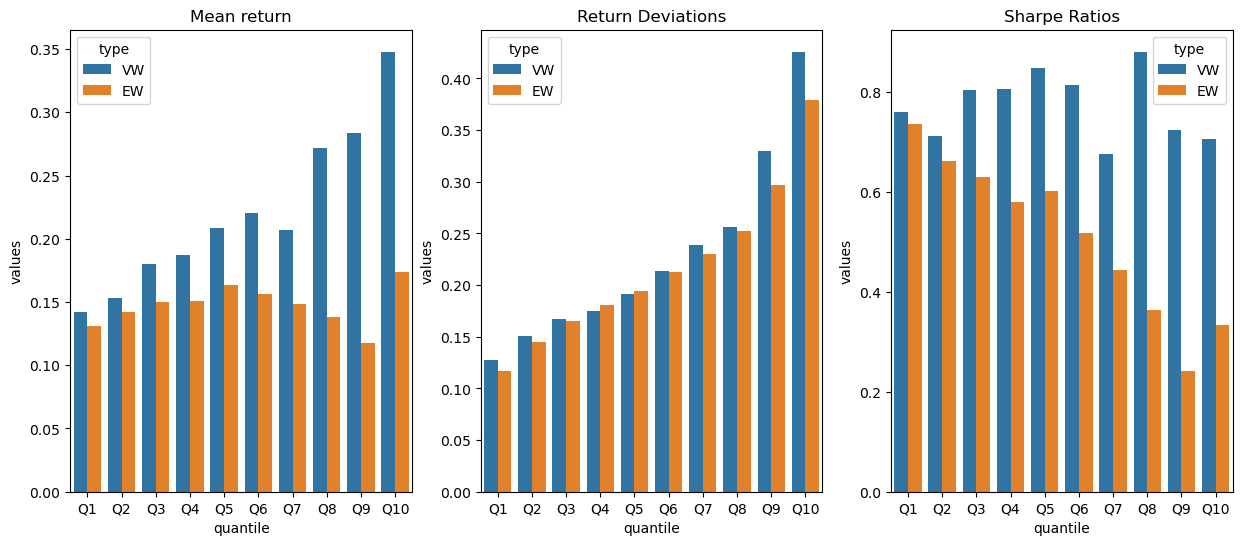

In [141]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()



## Constructing Volatility portfolio

In [142]:
##Construct three dataframes, one for the strategy and one for the higher deciels and lower decile portfolios
df_deciles=df5[df5['idio_q'].isin([0,1,2,7,8,9])].copy()
df_h=df_deciles[df_deciles['idio_q'].isin([7,8,9])]
df_l=df_deciles[df_deciles['idio_q'].isin([0,1,2])]

Equal weighted strategy

In [143]:
## Short the 3 lowest decile returns to apply the strategy
df_deciles['Rn']=df_deciles.apply(lambda row: (-1)*row['Rn'] if row['idio_q'] in [0,1, 2] else row['Rn'], axis=1)

In [144]:
## PRINTING THE PROPERTIES OF THE DIFFERENT STRATEGIES
mean_h=df_h['Rn'].mean()*12
mean_l=df_l['Rn'].mean()*12
mean_strat=df_deciles['Rn'].mean()*12

std_h=df_h['Rn'].std()*(np.sqrt(12))
std_l=df_l['Rn'].std()*(np.sqrt(12))
std_strat=df_deciles['Rn'].std()*(np.sqrt(12))

sr_h=(mean_h-df_h['rf'].mean())/(std_h)
sr_l=(mean_l-df_l['rf'].mean())/(std_l)
sr_strat=(mean_strat-df_deciles['rf'].mean())/(std_strat)


print('-----Annual Return Means-----')
print(f'High Deciles: {mean_h}, Low Deciles: {mean_l}, Strategy: {mean_strat}')
print('-----Annual Return Deviations-----')
print(f'High Deciles: {std_h}, Low Deciles: {std_l}, Strategy: {std_strat}')
print('-----Sharpe Ratios-----')
print(f'High Deciles: {sr_h}, Low Deciles: {sr_l}, Strategy: {sr_strat}')



-----Annual Return Means-----
High Deciles: 0.1311663026506812, Low Deciles: 0.13947677712575177, Strategy: -0.007679182874185328
-----Annual Return Deviations-----
High Deciles: 0.7587824156208495, Low Deciles: 0.2782079293938283, Strategy: 0.5671075065973975
-----Sharpe Ratios-----
High Deciles: 0.1677681272355872, Low Deciles: 0.4876418261180054, Strategy: -0.020308903907202705


In [145]:
## Statistical testing for pvalues
from scipy.stats import ttest_ind
_, pval=ttest_ind(df_deciles.groupby('date')['Rn'].mean()*12,0)
print(pval)

0.9822501277241381


The test's p-value is above 5%, we can conclude that the returns or our long short strategy are not statistically different that 0.

In [146]:

df_deciles['ret_vw']=df_deciles.apply(lambda row: (-1)*row['ret_vw'] if row['idio_q'] in [0,1, 2] else row['ret_vw'], axis=1)
df_deciles['is_long']=df_deciles.apply(lambda row:  0 if row['idio_q'] in [0,1, 2] else 1, axis=1)
df_deciles.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol,idio_q,vw_Q,ret_vw,is_long
0,10001,2010-05-28,-0.004829,6071.0,11.4000,69209.4000,66028.8000,0.000114,-0.079240,1,0.004715,-0.079354,0.149543,0,0.000022,-1.083125e-07,0
1,10001,2010-04-30,-0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,0.160241,1,0.000034,-4.252436e-06,0
2,10001,2010-03-31,-0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,0.212511,2,0.000034,-7.063250e-07,0
3,10001,2010-02-26,0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,0.199038,2,0.000030,1.993227e-08,0
4,10001,2010-01-29,0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,0.181530,1,0.000022,4.225192e-07,0


In [150]:
df_deciles['vw_Q2']=df_deciles['mcap']/(df_deciles.groupby(['date','is_long'])['mcap'].transform('sum'))
df_deciles['ret_vw2'] = df_deciles['vw_Q2']*df_deciles['Rn']

In [151]:
## PRINTING THE PROPERTIES OF THE DIFFERENT STRATEGIES
mean_h=df_deciles[df_deciles['idio_q'].isin([7,8,9])]['ret_vw2'].mean()*12
mean_l=df_deciles[df_deciles['idio_q'].isin([0,1,2])]['ret_vw2'].mean()*12
mean_strat=df_deciles['ret_vw'].mean()*12

std_h=df_deciles[df_deciles['idio_q'].isin([7,8,9])]['ret_vw2'].std()*(np.sqrt(12))
std_l==df_deciles[df_deciles['idio_q'].isin([0,1,2])]['ret_vw2'].std()*(np.sqrt(12))
std_strat=df_deciles['ret_vw2'].std()*(np.sqrt(12))

sr_h=(mean_h-df_h['rf'].mean())/(std_h)
sr_l=(mean_l-df_l['rf'].mean())/(std_l)
sr_strat=(mean_strat-df_deciles['rf'].mean())/(std_strat)


print('-----Annual Return Means-----')
print(f'High Deciles: {mean_h}, Low Deciles: {mean_l}, Strategy: {mean_strat}')
print('-----Annual Return Deviations-----')
print(f'High Deciles: {std_h}, Low Deciles: {std_l}, Strategy: {std_strat}')
print('-----Sharpe Ratios-----')
print(f'High Deciles: {sr_h}, Low Deciles: {sr_l}, Strategy: {sr_strat}')



-----Annual Return Means-----
High Deciles: 0.0005003035391538688, Low Deciles: -0.00025117861098489464, Strategy: 0.00032218183449051645
-----Annual Return Deviations-----
High Deciles: 0.0035840503476969633, Low Deciles: 0.2782079293938283, Strategy: 0.0026049201916501967
-----Sharpe Ratios-----
High Deciles: -0.9392988203097288, Low Deciles: -0.01460106840042939, Strategy: -1.3497408324193947


In [152]:
## Statistical testing for pvalues
_, pval=ttest_ind(df_deciles.groupby('date')['ret_vw2'].mean()*12,0)
print(pval)

0.8595397103661634


The test's p-value is above 5%, we can conclude that the returns or our long short strategy are not statistically different that 0.

# **PART 4: Momentum Protfolio**

In [153]:
df=pd.read_csv('data.csv',sep=';')
df['date'] = pd.to_datetime(df['date'])
df.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10001,2010-06-30,-0.043421,6080.0,10.8600,66028.8000,NaN,0.000135,-0.050780,1,-0.043556,-0.050915
1,10001,2010-05-28,0.004829,6071.0,11.4000,69209.4000,66028.80,0.000114,-0.079240,1,0.004715,-0.079354
2,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.40,0.000118,0.020036,1,0.124267,0.019918
3,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.30,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.37,0.000061,0.034744,1,-0.000717,0.034683


**MOMENTUM**

In [154]:
#Cumulative 12 month past return for each stock:
df=df.sort_values(['permno','date']).reset_index(drop=True)
df['LN_Cret12'] = df.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11,closed='left').sum()).values
df['Rn_f'] = df.groupby(['permno'])['Rn'].shift(-1)
df.head()

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_27732\2346461583.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['LN_Cret12'] = df.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11,closed='left').sum()).values


,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,LN_Cret12,Rn_f
0,10001,2009-12-31,0.162621,4361.0,10.3000,44918.3000,43871.6600,0.000032,0.028475,1,0.162589,0.028443,NaN,-0.018932
1,10001,2010-01-29,-0.018932,4361.0,10.0600,43871.6600,43646.6324,0.000013,-0.037172,1,-0.018945,-0.037185,NaN,-0.000656
2,10001,2010-02-26,-0.000656,4361.0,10.0084,43646.6324,44351.3700,0.000061,0.034744,1,-0.000717,0.034683,NaN,0.020643
3,10001,2010-03-31,0.020643,4361.0,10.1700,44351.3700,69137.3000,0.000112,0.063668,1,0.020531,0.063556,NaN,0.124385
4,10001,2010-04-30,0.124385,6070.0,11.3900,69137.3000,69209.4000,0.000118,0.020036,1,0.124267,0.019918,NaN,0.004829


In [155]:
df4=df.copy()
#Momentum decile weights
q = 10
#Momentum is the decile
df4['Momentum'] = df4.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
df4['w_L'] = (df4['Momentum']==q-1)*df4['mcap']
df4['w_S'] = (df4['Momentum']==0)*df4['mcap']
#Normalize the weights
df4['w_L'] = df4['w_L']/df4.groupby(['date'])['w_L'].transform('sum')
df4['w_S'] = df4['w_S']/df4.groupby(['date'])['w_S'].transform('sum')
df4['w_Mom'] = df4['w_L'] - df4['w_S']
Momentum = df4.groupby('date').apply(lambda x: np.sum(x['Rn_f']*x['w_Mom'])).reset_index()
Momentum['date'] =  Momentum['date'] + pd.DateOffset(months=1)
Momentum.columns = ['date','Mom_ret']

C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_27732\1375466105.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Momentum = df4.groupby('date').apply(lambda x: np.sum(x['Rn_f']*x['w_Mom'])).reset_index()


In [156]:
#Generate deciles
df_momentum=df4.dropna(subset=['Momentum']).copy()
df_momentum['momentum_deciles']=df_momentum.groupby('date')['Momentum'].transform(lambda x :  pd.qcut(x, 10,labels=False, duplicates='drop'))

#Equal-Weighted pfs
ret_ew = df_momentum.groupby(['date','momentum_deciles'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('momentum_deciles')['Rn'].mean()*12
ew_ret_std = ret_ew.groupby('momentum_deciles')['Rn'].std()*(np.sqrt(12))
ew_rf_mean=df_momentum.groupby('momentum_deciles')['rf'].mean()*12
ew_sr=(ew_ret_mean-ew_rf_mean)/(ew_ret_std)



# Value-weighed pfs
df_momentum['vw_Q']=df_momentum['mcap']/(df_momentum.groupby(['date','momentum_deciles'])['mcap'].transform('sum'))
df_momentum['ret_vw'] = df_momentum['vw_Q']*df_momentum['Rn']
ret_vw = df_momentum.groupby(['date','momentum_deciles'])['ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('momentum_deciles')['ret_vw'].mean()*12
vw_ret_std = ret_vw.groupby('momentum_deciles')['ret_vw'].std()*(np.sqrt(12))
vw_rf_mean=df_momentum.groupby('momentum_deciles')['rf'].mean()*12
vw_sr=(vw_ret_mean-vw_rf_mean)/(vw_ret_std)

In [157]:
#Constuct dataframes for efficient plotting 
deciles=['Q'+ str(x) for x in np.arange(1,11)]
means=np.concatenate((vw_ret_mean.values,ew_ret_mean.values))
means_df=pd.DataFrame(zip(means,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
stds=np.concatenate((vw_ret_std.values,ew_ret_std.values))
stds_df=pd.DataFrame(zip(stds,['VW']*len(vw_ret_mean.values)+['EW']*len(ew_ret_mean.values),deciles+deciles),columns=['values','type','quantile'])
srs=np.concatenate((vw_sr.values,ew_sr.values))
srs_df=pd.DataFrame(zip(srs,['VW']*len(vw_sr.values)+['EW']*len(ew_sr.values),deciles+deciles),columns=['values','type','quantile'])

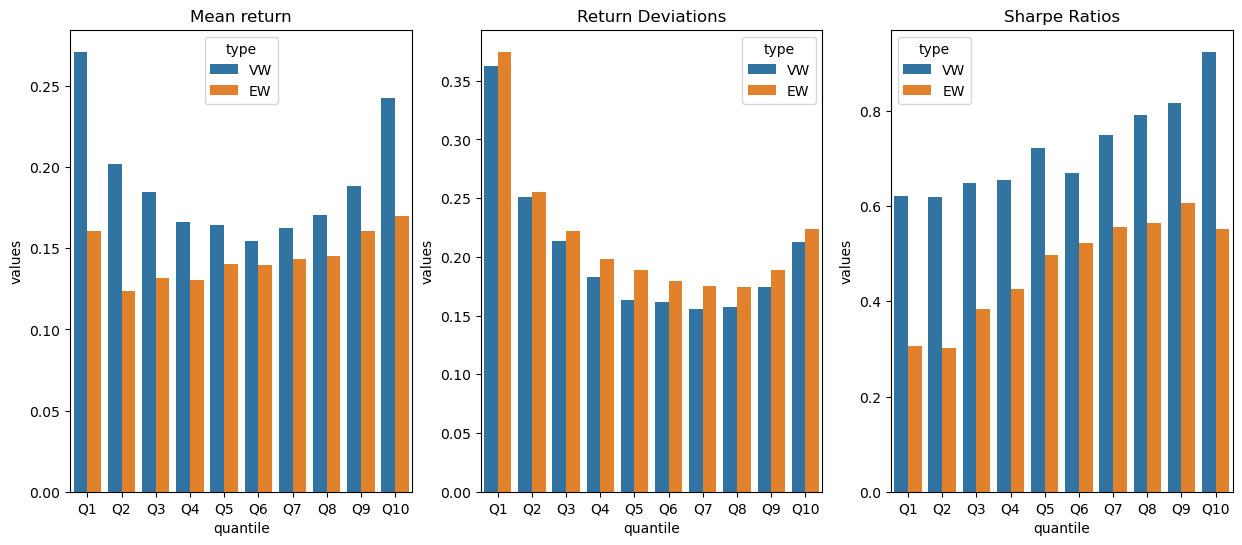

In [158]:
import seaborn as sns
# 5. Plot Means Histogram
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()

# **PART 6: Optimal Fund Portfolio Return**

In [159]:
target_volatility=0.1

In [160]:
BAB.head(2)

,date,R_H,R_L,R_H_e,R_L_e,beta_H,beta_L,BAB2
0,1964-04-30,-0.017565,0.005582,-0.020362,0.002785,1.952209,0.671324,0.014579
1,1964-08-31,-0.015725,0.003800,-0.018445,0.001080,1.963779,0.677657,0.010986


In [161]:
df_momentum.head(2)


,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,...,Rm_e,LN_Cret12,Rn_f,Momentum,w_L,w_S,w_Mom,momentum_deciles,vw_Q,ret_vw
11,10001,2010-11-30,-0.118436,7834.0,10.04,78653.36,82413.68,0.000142,0.005117,1,...,0.004975,0.297149,0.052291,7.0,0.0,0.0,0.0,7,0.000098,-0.000012
12,10001,2010-12-31,0.052291,7834.0,10.52,82413.68,84450.52,0.000068,0.067182,1,...,0.067114,0.020414,0.028992,3.0,0.0,0.0,0.0,3,0.000042,0.000002


In [162]:
df_deciles.head(2)

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,idio_vol,idio_q,vw_Q,ret_vw,is_long,vw_Q2,ret_vw2
0,10001,2010-05-28,-0.004829,6071.0,11.40,69209.4,66028.8,0.000114,-0.079240,1,0.004715,-0.079354,0.149543,0,0.000022,-1.083125e-07,0,0.000011,-5.313131e-08
1,10001,2010-04-30,-0.124385,6070.0,11.39,69137.3,69209.4,0.000118,0.020036,1,0.124267,0.019918,0.160241,1,0.000034,-4.252436e-06,0,0.000010,-1.238070e-06


In [163]:
r_bab=BAB.copy()
r_mom=df_momentum.groupby('date')['ret_vw'].sum().copy()
r_iv=df_deciles.groupby('date')['ret_vw2'].sum().copy()

In [164]:
r_strat=r_bab.merge(r_mom,on='date').merge(r_iv,on='date')
r_strat.rename(columns={'BAB2':'ret_bab',	'ret_vw':'ret_mom',	'ret_vw2':'ret_iv'},inplace=True)
r_strat=r_strat[['date','ret_bab', 'ret_mom', 'ret_iv']]
r_strat.head()

,date,ret_bab,ret_mom,ret_iv
0,1965-04-30,0.010264,0.399008,0.010634
1,1965-07-30,0.034245,0.262204,0.045524
2,1965-09-30,-0.014421,0.387232,0.048480
3,1966-01-31,0.005820,0.268936,0.097204
4,1966-02-28,0.022239,0.074483,0.127262


## Equal weighed returns

In [165]:
r_strat['ret_ew']= r_strat[['ret_bab', 'ret_mom', 'ret_iv']].mean(axis=1)
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew
0,1965-04-30,0.010264,0.399008,0.010634,0.139969
1,1965-07-30,0.034245,0.262204,0.045524,0.113991
2,1965-09-30,-0.014421,0.387232,0.048480,0.140431
3,1966-01-31,0.005820,0.268936,0.097204,0.123987
4,1966-02-28,0.022239,0.074483,0.127262,0.074661


## Risk parity

In [166]:
window_size=60
min_req=36
# Calculate rolling window volatility for each column
r_strat['volatility_bab'] = r_strat['ret_bab'].rolling(window=window_size,min_periods=min_req).std()
r_strat['volatility_mom'] = r_strat['ret_mom'].rolling(window=window_size,min_periods=min_req).std()
r_strat['volatility_iv'] = r_strat['ret_iv'].rolling(window=window_size,min_periods=min_req).std()

r_strat['total_vol']=(1/r_strat['volatility_bab'])+ (1/r_strat['volatility_mom' ])+ (1/r_strat['volatility_iv'])

r_strat['w_bab']=(1/r_strat['volatility_bab'])/r_strat['total_vol']    
r_strat['w_mom']=(1/r_strat['volatility_mom' ])/r_strat['total_vol']    
r_strat['w_iv']=(1/r_strat['volatility_iv'])/r_strat['total_vol']

r_strat['ret_rp']=r_strat['ret_bab']*r_strat['w_bab']+r_strat['ret_iv']*r_strat['w_iv']+r_strat['ret_mom']*r_strat['w_mom']

r_strat=r_strat[['date','ret_bab','ret_mom','ret_iv','ret_ew','ret_rp']]
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew,ret_rp
0,1965-04-30,0.010264,0.399008,0.010634,0.139969,NaN
1,1965-07-30,0.034245,0.262204,0.045524,0.113991,NaN
2,1965-09-30,-0.014421,0.387232,0.048480,0.140431,NaN
3,1966-01-31,0.005820,0.268936,0.097204,0.123987,NaN
4,1966-02-28,0.022239,0.074483,0.127262,0.074661,NaN


Setting up risk free rates for the mean variance efficient pf


In [167]:
rf_df=df.groupby('date')['rf'].mean()
r_strat=r_strat.merge(rf_df,on='date',how='left')
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew,ret_rp,rf
0,1965-04-30,0.010264,0.399008,0.010634,0.139969,NaN,0.003216
1,1965-07-30,0.034245,0.262204,0.045524,0.113991,NaN,0.003140
2,1965-09-30,-0.014421,0.387232,0.048480,0.140431,NaN,0.003322
3,1966-01-31,0.005820,0.268936,0.097204,0.123987,NaN,0.003776
4,1966-02-28,0.022239,0.074483,0.127262,0.074661,NaN,0.003716


## Mean Variance efficient

In [168]:
## TODO: add rf rates+ look at ps3 for rolling average and stds
def compute_tangency_w(data):
    rf=data['rf'].mean()
    cov=data[['ret_bab','ret_mom','ret_iv']].cov().values*12
    inv_cov=np.linalg.inv(cov)
    mu=np.array([data['ret_bab'].mean()-rf*12,data['ret_mom'].mean()-rf*12,data['ret_iv'].mean()-rf*12])
    w= (inv_cov @ mu)/(np.ones(3)@inv_cov@mu)
    return w

In [169]:
w=compute_tangency_w(r_strat)

In [170]:
r_strat['ret_mve']=w[0]*r_strat['ret_bab']+w[1]*r_strat['ret_mom']+w[2]*r_strat['ret_iv']
r_strat.head()

,date,ret_bab,ret_mom,ret_iv,ret_ew,ret_rp,rf,ret_mve
0,1965-04-30,0.010264,0.399008,0.010634,0.139969,NaN,0.003216,-0.004838
1,1965-07-30,0.034245,0.262204,0.045524,0.113991,NaN,0.003140,0.029709
2,1965-09-30,-0.014421,0.387232,0.048480,0.140431,NaN,0.003322,-0.005610
3,1966-01-31,0.005820,0.268936,0.097204,0.123987,NaN,0.003776,0.031188
4,1966-02-28,0.022239,0.074483,0.127262,0.074661,NaN,0.003716,0.061203


## Calculating constants

In [171]:
c_ew=np.sqrt(target_volatility**2/(r_strat['ret_ew'].std()**2))
c_rp=np.sqrt(target_volatility**2/(r_strat['ret_rp'].std()**2))
c_mve=np.sqrt(target_volatility**2/(r_strat['ret_mve'].std()**2))

print(f'Scaling constants EW:{c_ew}, RP:{c_rp}, MVE: {c_mve}')

Scaling constants EW:0.49941976573104097, RP:2.2974135156441347, MVE: 3.4886855886277153


In [172]:
#Constuct dataframes for efficient plotting 
strats=['EW','RP','MVE']
means=[r_strat['ret_ew'].mean(),r_strat['ret_rp'].mean(),r_strat['ret_mve'].mean()]
means_df=pd.DataFrame(zip(means,strats,strats),columns=['values','type','quantile'])
stds=[r_strat['ret_ew'].std(),r_strat['ret_rp'].std(),r_strat['ret_mve'].std()]
stds_df=pd.DataFrame(zip(stds,strats,strats),columns=['values','type','quantile'])
srs=(np.array(means)-np.array([r_strat['rf'].mean()]*3))/np.array(stds)
srs_df=pd.DataFrame(zip(srs,strats,strats),columns=['values','type','quantile'])

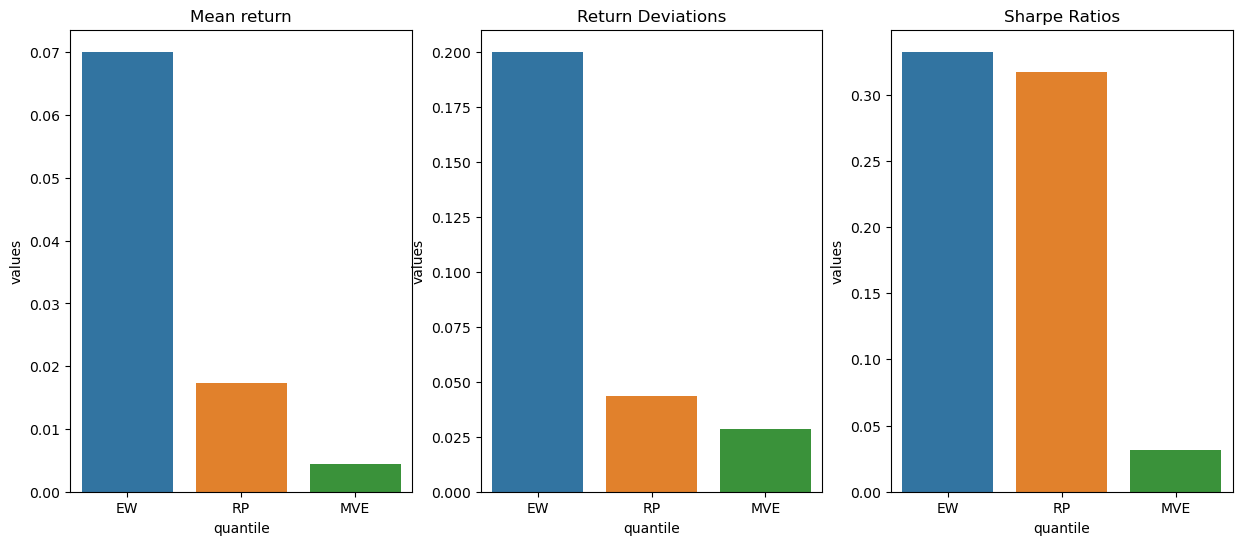

In [173]:
fig, axs= plt.subplots(1,3,figsize=(15,6))
sns.barplot(means_df,x='quantile',y='values',hue='type',ax=axs[0])
sns.barplot(stds_df,x='quantile',y='values',hue='type',ax=axs[1])
sns.barplot(srs_df,x='quantile',y='values',hue='type',ax=axs[2])

axs[0].set_title('Mean return')
axs[1].set_title('Return Deviations')
axs[2].set_title('Sharpe Ratios')
plt.show()

## 7 Performance and risk analysis for the Fund strategy

 Going forward, we pick the approach with the risk-parity

## a)

In [201]:
# Define the date range
start_date = '1964-01-01'
end_date = '2023-12-31'

In [202]:
Strat=r_strat[['date','ret_rp','rf']]

In [203]:
Industry_Returns = pd.read_csv('12_Industry_Portfolios.CSV')
Industry_Returns = Industry_Returns[(Industry_Returns['date'] >= start_date) & (Industry_Returns['date'] <= end_date)]
Industry_Returns['date'] = pd.to_datetime(Industry_Returns['date'], format='%Y%m', errors='coerce')+pd.offsets.MonthEnd(0)
Industry_Returns.head()

,date,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
450,1964-01-31,0.8,1.22,2.49,4.85,3.1,2.99,3.32,1.4,2.52,3.7,-1.18,2.77
451,1964-02-29,1.86,1.64,3.11,1.08,1.98,1.91,-0.28,0.87,1.63,1.65,3.85,6.37
452,1964-03-31,3.08,1.08,4.22,1.4,2.61,3.42,-0.9,-0.74,2.43,-1.94,0.68,3.39
453,1964-04-30,-0.47,1.8,-1.79,4.04,-1.48,-3.79,0.83,1.05,2.88,-1.42,-1.02,1.1
454,1964-05-31,1.56,1.52,1.58,2.15,2.09,2.83,-0.39,0.84,3.91,0.52,-0.03,3.85


In [212]:
#WE SHOULD DO SMTH LIKE THAT TO START FROM 1964 BUT SHIT AINT WORKING
#---------------------------------------------
# Industry Definitions  and Returns 
#---------------------------------------------

Industry_Definitions = pd.read_csv('48_Industry_Portfolios.CSV')
Industry_Definitions = Industry_Definitions.rename(columns={'SIC':'siccd'})
Industries = Industry_Returns.columns.tolist()
num_industries = len(Industries)
Industry_Names = pd.DataFrame(Industries, index=np.arange(1, num_industries+1)).reset_index()
Industry_Names.columns=['Industry','Name']

In [ ]:
#taking industries data from the data from ex7 BUT THE PROBLEM IS THAT IT STARTS FROM 1980 AND NOT 1964
Indus = pd.read_csv("Industries_ex7.csv",sep=";")
Indus['date'] = pd.to_datetime(Indus['date'])  # First, ensure that "date" is in datetime format
Indus.head()

,permno,start,ending,date,Rn,shrout,prc,siccd,rf,Rm,...,Hlth,Money,Other,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m
0,10006,1957-03-01,1984-07-18,1980-02-29,-0.058795,8859.0,38.500,3743.0,0.011347,0.001015,...,-0.057647,-0.061547,-0.027247,341071.500,367648.500,-0.172078,1,-0.070142,-0.010332,0.000491
1,10006,1957-03-01,1984-07-18,1980-03-31,-0.172078,8859.0,31.875,3743.0,0.012542,-0.120224,...,-0.040942,-0.101542,-0.169042,282380.625,341071.500,-0.027451,1,-0.184620,-0.132766,0.000456
2,10006,1957-03-01,1984-07-18,1980-04-30,-0.027451,8859.0,31.000,3743.0,0.007698,0.052287,...,0.035102,0.060602,0.044802,274629.000,282380.625,0.084677,1,-0.035149,0.044589,0.000421
3,10006,1957-03-01,1984-07-18,1980-05-30,0.084677,8859.0,33.000,3743.0,0.005985,0.060091,...,NaN,NaN,NaN,292347.000,274629.000,-0.007576,1,0.078692,0.054106,0.000391
4,10006,1957-03-01,1984-07-18,1980-06-30,-0.007576,8889.0,32.750,3743.0,0.005168,0.037714,...,-0.003068,0.043832,0.048332,291114.750,292347.000,0.091603,1,-0.012744,0.032546,0.000397


In [197]:
FF5=pd.read_csv('F-F_5_Factors.csv')
FF5['date'] = pd.to_datetime(FF5['date'], format='%Y%m', errors='coerce')+pd.offsets.MonthEnd(0)
FF5.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1,1963-08-31,5.07,-0.80,1.80,0.36,-0.35,0.25
2,1963-09-30,-1.57,-0.52,0.13,-0.71,0.29,0.27
3,1963-10-31,2.53,-1.39,-0.10,2.80,-2.01,0.29
4,1963-11-30,-0.85,-0.88,1.75,-0.51,2.24,0.27


In [198]:

# Filter the data to include only the dates within the specified range
FF5 = FF5[(FF5['date'] >= start_date) & (FF5['date'] <= end_date)]
# Display the first few rows of the filtered data
FF5.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
6,1964-01-31,2.24,0.13,1.48,0.17,1.47,0.30
7,1964-02-29,1.54,0.28,2.81,-0.05,0.91,0.26
8,1964-03-31,1.41,1.23,3.40,-2.21,3.22,0.31
9,1964-04-30,0.10,-1.52,-0.67,-1.27,-1.08,0.29
10,1964-05-31,1.42,-0.63,1.86,-0.16,0.17,0.26


In [216]:
# Inspect column names for any issues
print(Industry_Returns.columns)

# Check for leading/trailing whitespaces in column names
Industry_Returns.columns = Industry_Returns.columns.str.strip()

# Re-check column names after stripping whitespace
print(Industry_Returns.columns)

# Define the list of industry and Fama-French columns
Industries = ['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other']
Fama_French = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Merge the dataframes
tmp = pd.merge(Strat, Industry_Returns[['date'] + Industries].drop_duplicates(), on='date', how='left')
tmp['const'] = 1
tmp = tmp.merge(FF5, on='date', how='left')

for col in ['ret_rp'] + Industries + Fama_French:
    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')
    
tmp = tmp.dropna()

# Industry Exposure
import statsmodels.api as sm
RegOLS = sm.OLS(tmp['ret_rp'], tmp[['const'] + Industries + Fama_French]).fit()
print(f"regression parameters:{pd.concat([RegOLS.params, RegOLS.tvalues], axis=1)}")
print(f'R^2:{RegOLS.rsquared}')


Index(['date', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm',
       'Utils', 'Shops', 'Hlth', 'Money', 'Other'],
      dtype='object')
Index(['date', 'NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm',
       'Utils', 'Shops', 'Hlth', 'Money', 'Other'],
      dtype='object')
regression parameters:               0         1
const   0.007901  5.204465
NoDur  -0.000888 -1.095199
Durbl   0.000622  1.697492
Manuf   0.000605  0.630859
Enrgy  -0.000429 -2.001710
Chems   0.000494  0.672049
BusEq  -0.000655 -1.242014
Telcm   0.000258  0.624738
Utils   0.000007  0.015429
Shops   0.000101  0.143086
Hlth   -0.000088 -0.224708
Money   0.001618  2.384292
Other   0.002027  2.176707
Mkt-RF  0.002001  2.072077
SMB     0.002303  3.565072
HML     0.000252  0.271641
RMW    -0.000387 -0.494422
CMA     0.000661  0.645815
R^2:0.663860457873209


## b)